In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta 
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

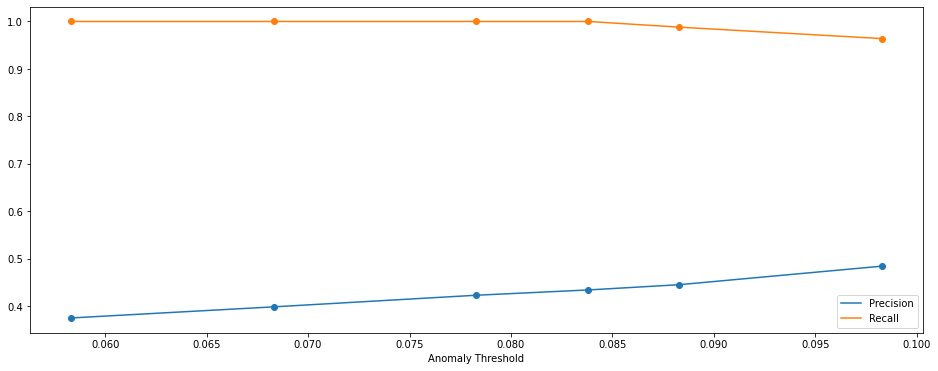

In [5]:
import matplotlib.pyplot as plt

thresholdValues = [0.0583, 0.0683, 0.0783, 0.0838, 0.0883, 0.0983]
precisionValues = [0.3756, 0.399, 0.4235, 0.4346, 0.4457, 0.4848]
recallValues = [1, 1, 1, 1, 0.988, 0.9639]

plt.figure(figsize=(16, 6))
plt.plot(thresholdValues, precisionValues)
plt.scatter(thresholdValues, precisionValues)
plt.plot(thresholdValues, recallValues)
plt.scatter(thresholdValues, recallValues)
plt.xlabel('Anomaly Threshold')
plt.legend(['Precision', 'Recall'], loc='lower right')
plt.show()

# Load Dataset

Make sure that training and validation set end at episode.

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul

In [7]:
#drop na columns 
all_df = all_df.dropna()

In [8]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [10]:
def getSensorReadingsOnlyNoEpisode(lst):
    result = []
    time = []
    for episode in lst:
        for row in episode:
            row_formatted = row[1:5]
            result.append(row_formatted)
            time.append(row[0])
    return (result, time)

In [11]:
#set random seed 
import tensorflow as tf
tf.random.set_seed(42)

In [12]:
train_arr, trainTime = getSensorReadingsOnlyNoEpisode(train_data)
val_arr, valTime = getSensorReadingsOnlyNoEpisode(val_data)
test_arr, testTime = getSensorReadingsOnlyNoEpisode(test_data)

In [13]:
train_arr

[[0.379151092, 0.556385187, 0.243079506, 0.229504293],
 [0.415506993, 0.698561103, 0.242410288, 0.273824561],
 [0.33934205, 0.637644818, 0.230266358, 0.191588098],
 [0.343817356, 0.627731997, 0.233904513, 0.264566349],
 [0.310361557, 0.607368113, 0.194295643, 0.240200195],
 [0.336327636, 0.531479142, 0.215693485, 0.215780325],
 [0.397831149, 0.57521239, 0.190585546, 0.230599092],
 [0.385974096, 0.630933953, 0.208516333, 0.247693397],
 [0.376943194, 0.396047283, 0.215659658, 0.256992779],
 [0.56498231, 0.648197926, 0.516587151, 0.256162471],
 [0.351867147, 0.647795783, 0.257161825, 0.276671218],
 [0.353867353, 0.615858294, 0.197009134, 0.269388231],
 [0.384169823, 0.622861995, 0.199791766, 0.305659257],
 [0.353154082, 0.597895409, 0.2172971, 0.265631153],
 [0.382126061, 0.655505276, 0.231748822, 0.258702261],
 [0.374770865, 0.676145451, 0.243662648, 0.259956326],
 [0.406003625, 0.626204276, 0.246397078, 0.26882794],
 [0.351261256, 0.265259177, 0.168831064, 0.441434541],
 [0.322982599, 0

In [14]:
def getStateValues(lst):
    stateList = []
    for episode in lst:
        for row in episode:
            stateValue = int(row[6])
            stateList.append(stateValue)
    return stateList

In [15]:
train_state = getStateValues(train_data)
val_state = getStateValues(val_data)
test_state = getStateValues(test_data)

In [16]:
def viewOutliers(clf):
    #training set
    y_train_scores = clf.decision_scores_
    plt.hist(y_train_scores, bins='auto') 
    plt.title("Histogram for training set anomaly scores")
    plt.show()
    
    #validation set
    y_val_scores = clf.decision_function(val_arr)  # outlier scores
    y_val_scores = pd.Series(y_val_scores)
    plt.hist(y_val_scores, bins='auto') 
    plt.title("Histogram for validation set anomaly scores")
    plt.show()

In [17]:
def getNormalSensorReadings(data_arr, stateList, stateThreshold):
    output = []
    for order in range(len(data_arr)):
        currentState = stateList[order]
        if currentState < stateThreshold: #threshold
            sensorArr = data_arr[order]
            output.append(sensorArr)
    return output

In [18]:
trainNormal = getNormalSensorReadings(train_arr, train_state, 4)
len(trainNormal)

5509

In [19]:
trainValSplit = int(0.85*len(trainNormal))
trainNormal1 = trainNormal[:trainValSplit]
trainNormal2 = trainNormal[trainValSplit:]

In [20]:
trainNormal1_arr = np.array(trainNormal1)
trainNormal2_arr = np.array(trainNormal2)

In [21]:
trainNormal1_arr.shape

(4682, 4)

In [22]:
trainNormal2_arr.shape

(827, 4)

# Hyperparameter Tuning

### Activation function (ends)

Original is tanh as ending activation function. Try out relu

In [23]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation="relu")(input_layer)
encoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(3, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(4, activation='relu')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
 dense_3 (Dense)             (None, 2)                 4         
                                                                 
 dense_4 (Dense)             (None, 3)                 9         
                                                                 
 dense_5 (Dense)             (None, 4)                 16    

In [24]:
fileName1 = "AE_tuneActivation_ends_relu.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName1,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [25]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [26]:
history = autoencoder.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 12s 7ms/step - loss: 0.1359 - mean_squared_error: 0.1359 - val_loss: 0.1311 - val_mean_squared_error: 0.1311
Epoch 2/500
147/147 [==============================] - 1s 4ms/step - loss: 0.1311 - mean_squared_error: 0.1311 - val_loss: 0.1311 - val_mean_squared_error: 0.1311
Epoch 3/500
147/147 [==============================] - 1s 4ms/step - loss: 0.1311 - mean_squared_error: 0.1311 - val_loss: 0.1310 - val_mean_squared_error: 0.1310
Epoch 4/500
147/147 [==============================] - 1s 4ms/step - loss: 0.1311 - mean_squared_error: 0.1311 - val_loss: 0.1310 - val_mean_squared_error: 0.1310
Epoch 5/500
147/147 [==============================] - 1s 4ms/step - loss: 0.1310 - mean_squared_error: 0.1310 - val_loss: 0.1310 - val_mean_squared_error: 0.1310
Epoch 6/500
147/147 [==============================] - 1s 4ms/step - loss: 0.1310 - mean_squared_error: 0.1310 - val_loss: 0.1309 - val_mean_squared_error: 0.1309
Epoch 7/500
147/147 [

147/147 [==============================] - 1s 3ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 52/500
147/147 [==============================] - 1s 4ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 53/500
147/147 [==============================] - 1s 4ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 54/500
147/147 [==============================] - 1s 4ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 55/500
147/147 [==============================] - 0s 3ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 56/500
147/147 [==============================] - 1s 7ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 57/500
147/147 [=======

147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 102/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 103/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 104/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 105/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 106/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 152/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 153/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 154/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 155/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 156/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 157/

Epoch 250/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 251/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 252/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 253/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 254/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 255/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 256/

Epoch 349/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 350/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 351/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 352/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 353/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 354/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 355/

Epoch 448/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 449/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 450/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 451/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 452/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 453/500
147/147 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 454/

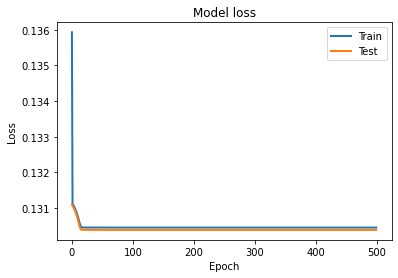

In [27]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [25]:
autoencoder = tf.keras.models.load_model("AE_tuneActivation_ends_relu.h5")

Determine Anomaly Threshold

In [32]:
def findFailureIndex(data):
    orderlist = []
    for order in range(len(data)):
        if data[order] > 3:
            orderlist.append(order)
    return orderlist

In [33]:
def findDegradeIndex(data): #includes state 3
    orderlist = []
    for order in range(len(data)):
        if data[order] > 2:
            orderlist.append(order)
    return orderlist

In [34]:
def getNormalIndex(data):
    orderlist = []
    for order in range(len(data)):
        if data[order] < 4:
            orderlist.append(order)
    return orderlist

In [35]:
def getValuebyIndex(data, indexList):
    output = []
    for order in indexList:
        output.append(data[order])
    return output

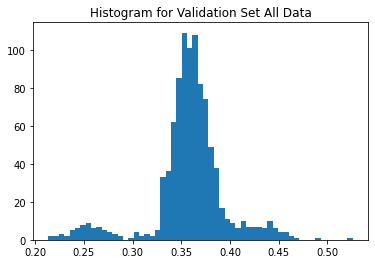

In [30]:
val_predictions = autoencoder.predict(val_arr)
val_score = (np.mean(np.power(val_arr - val_predictions, 2), axis=1))**0.5
plt.hist(val_score, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

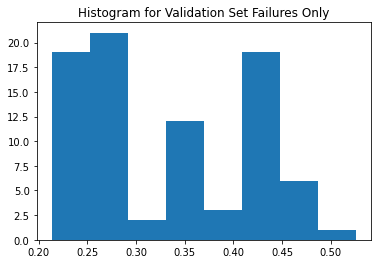

In [31]:
#find anomaly threshold by state
#failure data 
val_failureIndex = findFailureIndex(val_state)
val_failureScores = getValuebyIndex(val_score, val_failureIndex)
plt.hist(val_failureScores, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

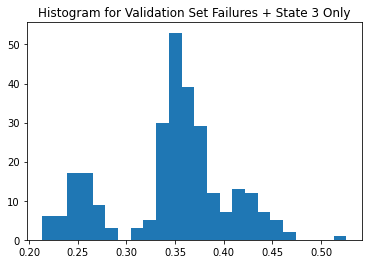

In [32]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex = findDegradeIndex(val_state)
val_degradationScores = getValuebyIndex(val_score, val_degradationIndex)
plt.hist(val_degradationScores, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

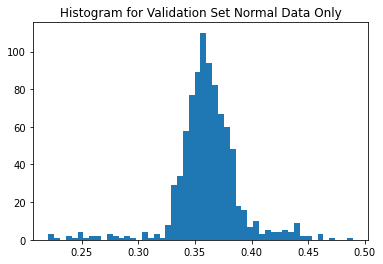

In [33]:
#normal data 
val_normalIndex = getNormalIndex(val_state)
val_normalScores = getValuebyIndex(val_score, val_normalIndex)
plt.hist(val_normalScores, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [34]:
import statistics
#find mean (validation)
valMean_normal = statistics.mean(val_normalScores)
valMean_normal

0.3612183269210789

In [35]:
#find standard deviation (validation)
valStdev_normal = statistics.stdev(val_normalScores)
valStdev_normal

0.02915600914039987

In [36]:
#1 standard deviation away 
valMean_normal + valStdev_normal

0.39037433606147875

In [37]:
#2 standard deviation away 
valMean_normal + valStdev_normal*2

0.41953034520187865

In [45]:
allValuesList = dataset.values.tolist()
allValuesList

[[0.0, 0.379151092, 0.556385187, 0.243079506, 0.229504293, 0.0],
 [1.0, 0.415506993, 0.698561103, 0.242410288, 0.273824561, 1.0],
 [2.0, 0.33934205, 0.637644818, 0.230266358, 0.191588098, 2.0],
 [3.0, 0.343817356, 0.627731997, 0.233904513, 0.264566349, 2.0],
 [4.0, 0.310361557, 0.607368113, 0.194295643, 0.240200195, 2.0],
 [5.0, 0.336327636, 0.531479142, 0.215693485, 0.215780325, 2.0],
 [6.0, 0.397831149, 0.57521239, 0.190585546, 0.230599092, 2.0],
 [7.0, 0.385974096, 0.630933953, 0.208516333, 0.247693397, 2.0],
 [8.0, 0.376943194, 0.396047283, 0.215659658, 0.256992779, 3.0],
 [9.0, 0.56498231, 0.648197926, 0.516587151, 0.256162471, 4.0],
 [10.0, 0.351867147, 0.647795783, 0.257161825, 0.276671218, 0.0],
 [11.0, 0.353867353, 0.615858294, 0.197009134, 0.269388231, 0.0],
 [12.0, 0.384169823, 0.622861995, 0.199791766, 0.305659257, 0.0],
 [13.0, 0.353154082, 0.597895409, 0.2172971, 0.265631153, 1.0],
 [14.0, 0.382126061, 0.655505276, 0.231748822, 0.258702261, 2.0],
 [15.0, 0.374770865, 0.67

In [36]:
def processAnomalyWithoutState3(anomalyScores, data, threshold, dataType):
    
    #initialise variables
    anomalousStateListTrain = []
    anomalousStatePreListTrain = []
    anomalousStatePostListTrain = []
    anomalousCountTrain = 0
    
    anomalousStateListVal = []
    anomalousStatePreListVal = []
    anomalousStatePostListVal = []
    anomalousCountVal = 0
    
    anomalousStateListTest = []
    anomalousStatePreListTest = []
    anomalousStatePostListTest = []
    anomalousCountTest = 0
    
    for order in range(0, len(anomalyScores)):
        score = anomalyScores[order]
        if score > threshold: #is anomaly
            reading = data[order]
            
            #process anomaly and count 
            anomalousIndex = 0
            for n in range(0, len(allValuesList)):
                row = allValuesList[n]
                if row[1:5] == reading: #is anomaly
                    anomalousIndex = n
                    if (dataType == 'Train'):
                        anomalousStateListTrain.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTrain.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTrain.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTrain =  anomalousCountTrain + 1
                    elif (dataType == 'Val'):
                        anomalousStateListVal.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListVal.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListVal.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountVal =  anomalousCountVal + 1
                    elif (dataType == 'Test'):
                        anomalousStateListTest.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTest.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTest.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTest =  anomalousCountTest + 1
                    break
        
    #graphical analysis 
    if (dataType == 'Train'):
        graphData = anomalousStateListTrain
    elif (dataType == 'Val'):
        graphData = anomalousStateListVal
    elif (dataType == 'Test'):
        graphData = anomalousStateListTest
        
    plt.hist(graphData, bins=[0,1,2,3,4,5,6])
    plt.title(f'Current anomalous state - {dataType}')
    plt.show()
    
    #numerical analysis 
    if (dataType == 'Train'):
        #training set
        train4count = anomalousStateListTrain.count(4.0)
        train5count = anomalousStateListTrain.count(5.0)
        train45count = train4count + train5count
        traintotalcount = len(anomalousStateListTrain)
        train4percent = train4count/traintotalcount
        train5percent = train5count/traintotalcount
        train45percent = train45count/traintotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in training set: %f" % train45percent)
        
        orgTrain4Count = train_state.count(4)
        orgTrain5Count = train_state.count(5)
        orgTrain45Count = orgTrain4Count + orgTrain5Count
        orgtrain4percent = train4count/orgTrain4Count
        orgtrain5percent = train5count/orgTrain5Count
        orgtrain45percent = train45count/orgTrain45Count
        print("Percentage of points in state 4 and 5 in training set identified as anomalies: %f" % orgtrain45percent)
    elif (dataType == 'Val'): #validation set
        val4count = anomalousStateListVal.count(4.0)
        val5count = anomalousStateListVal.count(5.0)
        val45count = val4count + val5count
        valtotalcount = len(anomalousStateListVal)
        val4percent = val4count/valtotalcount
        val5percent = val5count/valtotalcount
        val45percent = val45count/valtotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in validation set: %f" % val45percent)
        
        orgVal4Count = val_state.count(4)
        orgVal5Count = val_state.count(5)
        orgVal45Count = orgVal4Count + orgVal5Count
        orgVal4percent = val4count/orgVal4Count
        orgVal5percent = val5count/orgVal5Count
        orgVal45percent = val45count/orgVal45Count
        print("Percentage of points in state 4 and 5 in validation set identified as anomalies: %f" % orgVal45percent)
    elif (dataType == 'Test'): #test set
        test4count = anomalousStateListTest.count(4.0)
        test5count = anomalousStateListTest.count(5.0)
        test45count = test4count + test5count
        testtotalcount = len(anomalousStateListTest)
        test4percent = test4count/testtotalcount
        test5percent = test5count/testtotalcount
        test45percent = test45count/testtotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in test set: %f" % test45percent)
        
        orgTest4Count = test_state.count(4)
        orgTest5Count = test_state.count(5)
        orgTest45Count = orgTest4Count + orgTest5Count
        orgTest4percent = test4count/orgTest4Count
        orgTest5percent = test5count/orgTest5Count
        orgTest45percent = test45count/orgTest45Count
        print("Percentage of points in state 4 and 5 in test set identified as anomalies: %f" % orgTest45percent)

In [37]:
def processAnomalyWithState3(anomalyScores, data, threshold, dataType):
    
    #initialise variables
    anomalousStateListTrain = []
    anomalousStatePreListTrain = []
    anomalousStatePostListTrain = []
    anomalousCountTrain = 0
    
    anomalousStateListVal = []
    anomalousStatePreListVal = []
    anomalousStatePostListVal = []
    anomalousCountVal = 0
    
    anomalousStateListTest = []
    anomalousStatePreListTest = []
    anomalousStatePostListTest = []
    anomalousCountTest = 0
    
    for order in range(0, len(anomalyScores)):
        score = anomalyScores[order]
        if score > threshold: #is anomaly
            reading = data[order]
            
            #process anomaly and count 
            anomalousIndex = 0
            for n in range(0, len(allValuesList)):
                row = allValuesList[n]
                if row[1:5] == reading: #is anomaly
                    anomalousIndex = n
                    if (dataType == 'Train'):
                        anomalousStateListTrain.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTrain.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTrain.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTrain =  anomalousCountTrain + 1
                    elif (dataType == 'Val'):
                        anomalousStateListVal.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListVal.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListVal.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountVal =  anomalousCountVal + 1
                    elif (dataType == 'Test'):
                        anomalousStateListTest.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTest.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTest.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTest =  anomalousCountTest + 1
                    break
        
    #graphical analysis 
    if (dataType == 'Train'):
        graphData = anomalousStateListTrain
    elif (dataType == 'Val'):
        graphData = anomalousStateListVal
    elif (dataType == 'Test'):
        graphData = anomalousStateListTest
        
    plt.hist(graphData, bins=[0,1,2,3,4,5,6])
    plt.title(f'Current anomalous state - {dataType}')
    plt.show()
    
    #numerical analysis 
    if (dataType == 'Train'):
        #training set
        train3count = anomalousStateListTrain.count(3.0)
        train4count = anomalousStateListTrain.count(4.0)
        train5count = anomalousStateListTrain.count(5.0)
        train345count = train3count + train4count + train5count
        traintotalcount = len(anomalousStateListTrain)
        train345percent = train345count/traintotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in training set: %f" % train345percent)
        
        orgTrain3Count = train_state.count(3)
        orgTrain4Count = train_state.count(4)
        orgTrain5Count = train_state.count(5)
        orgTrain345Count = orgTrain3Count + orgTrain4Count + orgTrain5Count
        orgtrain345percent = train345count/orgTrain345Count
        print("Percentage of points in state 3, 4 and 5 in training set identified as anomalies: %f" % orgtrain345percent)
    elif (dataType == 'Val'): #validation set
        val3count = anomalousStateListVal.count(3.0)
        val4count = anomalousStateListVal.count(4.0)
        val5count = anomalousStateListVal.count(5.0)
        val345count = val3count + val4count + val5count
        valtotalcount = len(anomalousStateListVal)
        val345percent = val345count/valtotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: %f" % val345percent)
        
        orgVal3Count = val_state.count(3)
        orgVal4Count = val_state.count(4)
        orgVal5Count = val_state.count(5)
        orgVal345Count = orgVal3Count + orgVal4Count + orgVal5Count
        orgVal345percent = val345count/orgVal345Count
        print("Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: %f" % orgVal345percent)
    elif (dataType == 'Test'): #test set
        test3count = anomalousStateListTest.count(3.0)
        test4count = anomalousStateListTest.count(4.0)
        test5count = anomalousStateListTest.count(5.0)
        test345count = test3count + test4count + test5count
        testtotalcount = len(anomalousStateListTest)
        test345percent = test345count/testtotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in test set: %f" % test345percent)
        
        orgTest3Count = test_state.count(3)
        orgTest4Count = test_state.count(4)
        orgTest5Count = test_state.count(5)
        orgTest345Count = orgTest3Count + orgTest4Count + orgTest5Count
        orgTest345percent = test345count/orgTest345Count
        print("Percentage of points in state 3, 4 and 5 in test set identified as anomalies: %f \n" % orgTest345percent)

Current threshold value: 0.3704


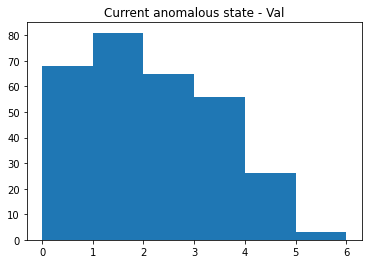

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.096990
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.349398


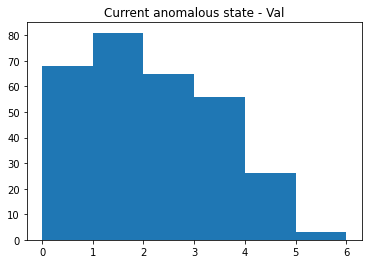

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.284281
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.307971
Current threshold value: 0.3804


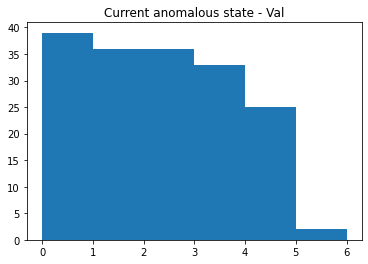

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.157895
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.325301


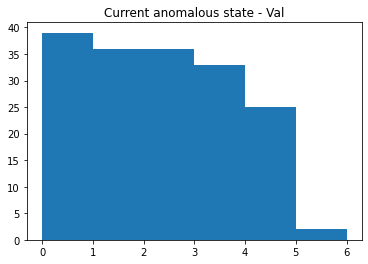

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.350877
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.217391
Current threshold value: 0.3904


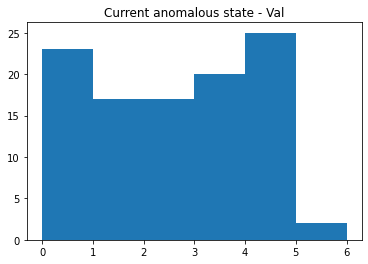

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.259615
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.325301


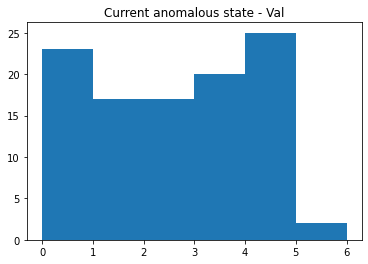

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.451923
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.170290
Current threshold value: 0.4004


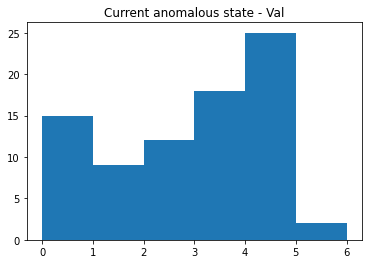

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.333333
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.325301


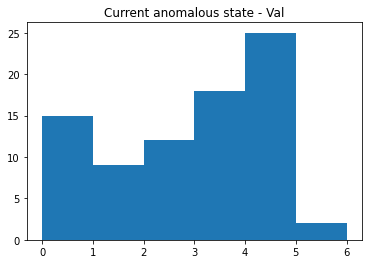

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.555556
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.163043
Current threshold value: 0.4104


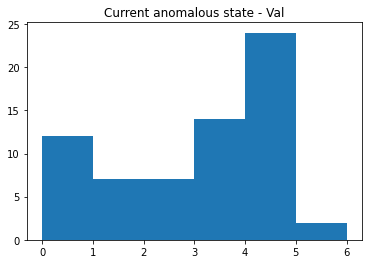

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.393939
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.313253


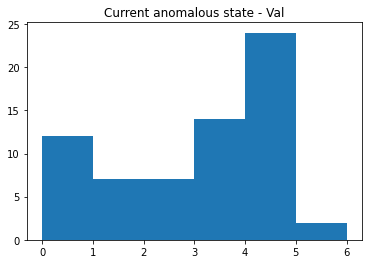

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.606061
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.144928


In [41]:
thresholdTest = [0.370374, 0.380374, 0.390374, 0.400374, 0.410374]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score, val_arr, value, 'Val')
    processAnomalyWithState3(val_score, val_arr, value, 'Val')

leaky relu

In [43]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation=tf.nn.leaky_relu)(input_layer)
encoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(3, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(4, activation=tf.nn.leaky_relu)(decoder)
#Autoencoder
autoencoder2 = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_12 (Dense)            (None, 3)                 15        
                                                                 
 dense_13 (Dense)            (None, 2)                 8         
                                                                 
 dense_14 (Dense)            (None, 1)                 3         
                                                                 
 dense_15 (Dense)            (None, 2)                 4         
                                                                 
 dense_16 (Dense)            (None, 3)                 9         
                                                                 
 dense_17 (Dense)            (None, 4)                 16  

In [44]:
fileName2 = "AE_tuneActivation_ends_leakyRelu.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName2,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [45]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder2.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [47]:
history2 = autoencoder2.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0825 - mean_squared_error: 0.0825 - val_loss: 0.0260 - val_mean_squared_error: 0.0260
Epoch 2/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 3/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 4/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 5/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 6/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 7/500
147/147 [=

147/147 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 52/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 53/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 54/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 55/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 56/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 57/500
147/147 [=======

147/147 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 102/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 103/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 104/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 105/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 106/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 152/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 153/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 154/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 155/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 156/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 157/

Epoch 250/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 251/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 252/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 253/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 254/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 255/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 256/

Epoch 349/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 350/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 351/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 352/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 353/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 354/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 355/

Epoch 448/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 449/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 450/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 451/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 452/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 453/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 454/

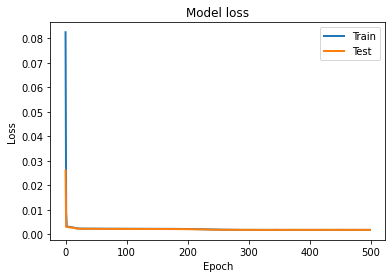

In [48]:
plt.plot(history2['loss'], linewidth=2, label='Train')
plt.plot(history2['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [49]:
autoencoder2 = tf.keras.models.load_model("AE_tuneActivation_ends_leakyRelu.h5")

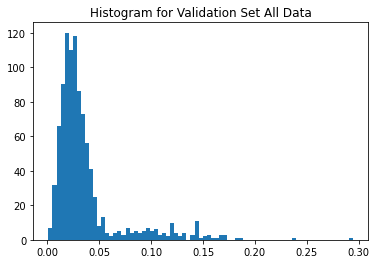

In [50]:
val_predictions2 = autoencoder2.predict(val_arr)
val_score2 = (np.mean(np.power(val_arr - val_predictions2, 2), axis=1))**0.5
plt.hist(val_score2, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

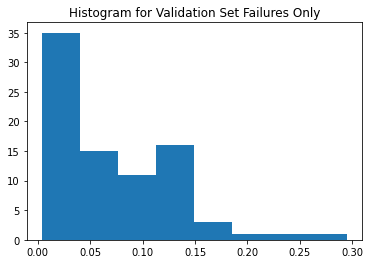

In [51]:
#find anomaly threshold by state
#failure data 
val_failureIndex2 = findFailureIndex(val_state)
val_failureScores2 = getValuebyIndex(val_score2, val_failureIndex2)
plt.hist(val_failureScores2, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

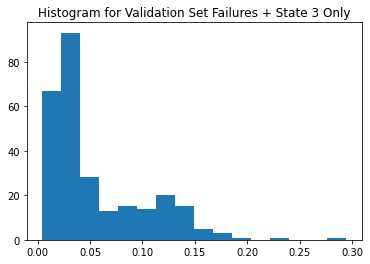

In [52]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex2 = findDegradeIndex(val_state)
val_degradationScores2 = getValuebyIndex(val_score2, val_degradationIndex2)
plt.hist(val_degradationScores2, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

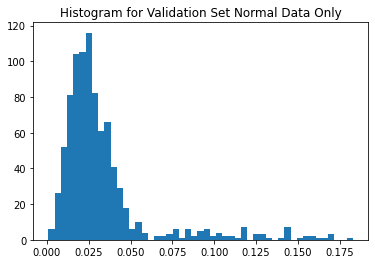

In [53]:
#normal data 
val_normalIndex2 = getNormalIndex(val_state)
val_normalScores2 = getValuebyIndex(val_score2, val_normalIndex2)
plt.hist(val_normalScores2, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [54]:
#find mean (validation)
valMean_normal2 = statistics.mean(val_normalScores2)
valMean_normal2

0.032804790286170546

In [55]:
#find standard deviation (validation)
valStdev_normal2 = statistics.stdev(val_normalScores2)
valStdev_normal2

0.0279555425772263

In [56]:
#1 standard deviation away 
valMean_normal2 + valStdev_normal2

0.06076033286339685

In [57]:
#2 standard deviation away 
valMean_normal2 + valStdev_normal2*2

0.08871587544062315

Current threshold value: 0.0408


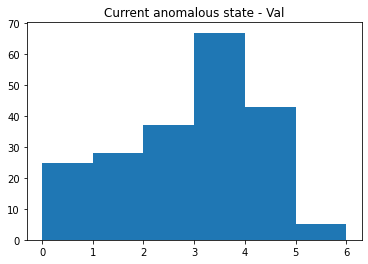

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.234146
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.578313


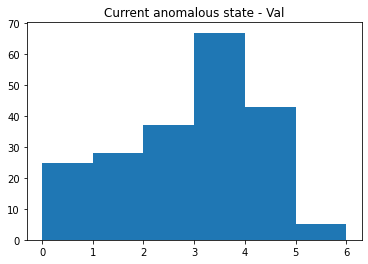

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.560976
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.416667
Current threshold value: 0.0508


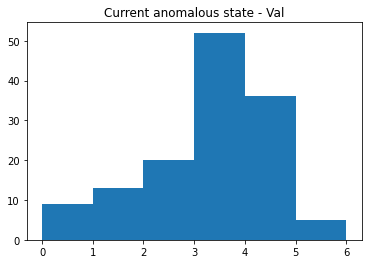

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.303704
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.493976


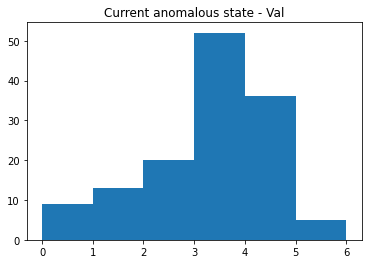

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.688889
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.336957
Current threshold value: 0.0608


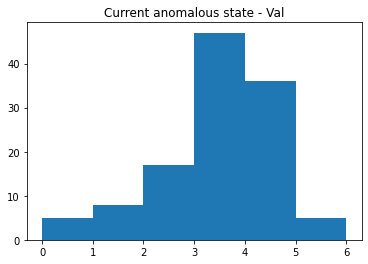

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.347458
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.493976


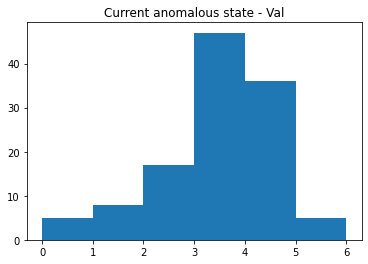

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.745763
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.318841
Current threshold value: 0.0708


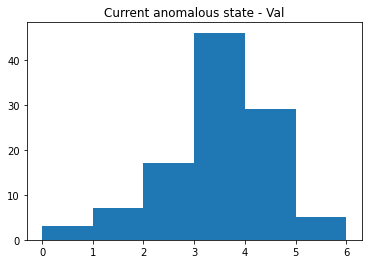

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.317757
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.409639


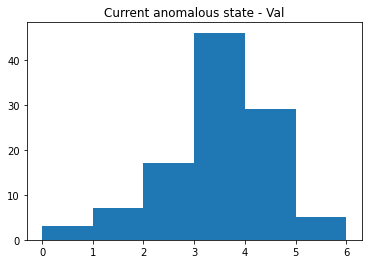

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.747664
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.289855
Current threshold value: 0.0808


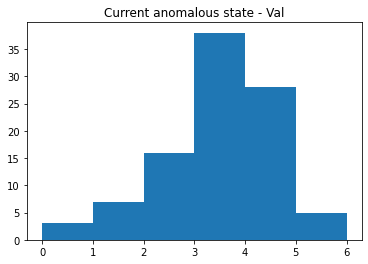

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.340206
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.397590


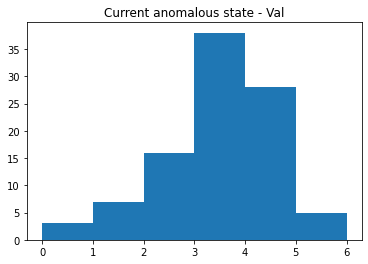

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.731959
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.257246


In [59]:
thresholdTest = [0.0408, 0.0508, 0.0608, 0.0708, 0.0808]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score2, val_arr, value, 'Val')
    processAnomalyWithState3(val_score2, val_arr, value, 'Val')

sigmoid

In [62]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation='sigmoid')(input_layer)
encoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(3, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(4, activation='sigmoid')(decoder)
#Autoencoder
autoencoder3 = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_30 (Dense)            (None, 3)                 15        
                                                                 
 dense_31 (Dense)            (None, 2)                 8         
                                                                 
 dense_32 (Dense)            (None, 1)                 3         
                                                                 
 dense_33 (Dense)            (None, 2)                 4         
                                                                 
 dense_34 (Dense)            (None, 3)                 9         
                                                                 
 dense_35 (Dense)            (None, 4)                 16  

In [65]:
fileName3 = "AE_tuneActivation_ends_sigmoid.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName3,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [66]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder3.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [67]:
history3 = autoencoder3.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - val_loss: 0.0328 - val_mean_squared_error: 0.0328
Epoch 2/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 3/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 4/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 5/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 6/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 7/500
147/147 [=

147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 52/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 53/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 54/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 55/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 56/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 57/500
147/147 [=======

147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 102/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 103/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 104/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 105/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 106/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 152/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 153/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 154/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 155/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 156/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 157/

Epoch 250/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 251/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 252/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 253/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 254/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 255/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 256/

Epoch 349/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 350/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 351/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 352/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 353/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 354/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 355/

Epoch 448/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 449/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 450/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 451/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 452/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 453/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 454/

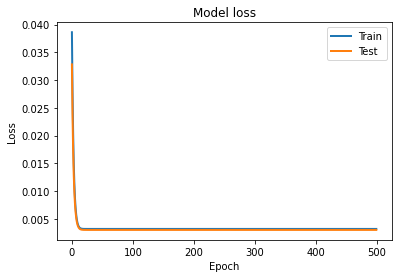

In [68]:
plt.plot(history3['loss'], linewidth=2, label='Train')
plt.plot(history3['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [69]:
autoencoder3 = tf.keras.models.load_model("AE_tuneActivation_ends_sigmoid.h5")

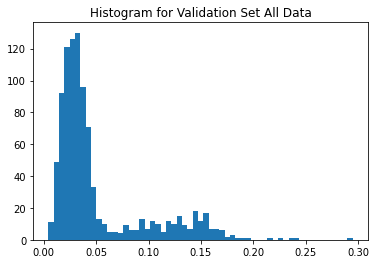

In [70]:
val_predictions3 = autoencoder3.predict(val_arr)
val_score3 = (np.mean(np.power(val_arr - val_predictions3, 2), axis=1))**0.5
plt.hist(val_score3, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

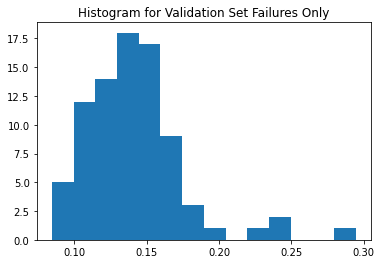

In [71]:
#find anomaly threshold by state
#failure data 
val_failureIndex3 = findFailureIndex(val_state)
val_failureScores3 = getValuebyIndex(val_score3, val_failureIndex3)
plt.hist(val_failureScores3, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

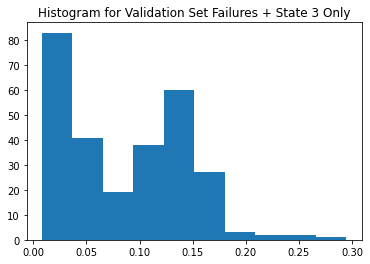

In [72]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex3 = findDegradeIndex(val_state)
val_degradationScores3 = getValuebyIndex(val_score3, val_degradationIndex3)
plt.hist(val_degradationScores3, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

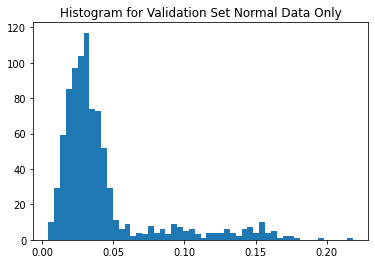

In [73]:
#normal data 
val_normalIndex3 = getNormalIndex(val_state)
val_normalScores3 = getValuebyIndex(val_score3, val_normalIndex3)
plt.hist(val_normalScores3, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [74]:
#find mean (validation)
valMean_normal3 = statistics.mean(val_normalScores3)
valMean_normal3

0.04265374586716519

In [75]:
#find standard deviation (validation)
valStdev_normal3 = statistics.stdev(val_normalScores3)
valStdev_normal3

0.03563591737175158

In [76]:
#1 standard deviation away 
valMean_normal3 + valStdev_normal3

0.07828966323891676

In [77]:
#2 standard deviation away 
valMean_normal3 + valStdev_normal3*2

0.11392558061066835

Current threshold value: 0.0583


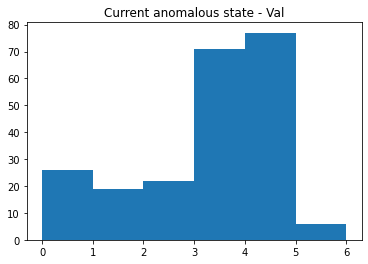

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.375566
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


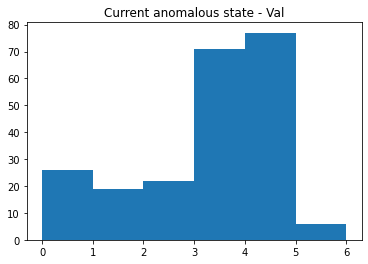

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.696833
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.557971
Current threshold value: 0.0683


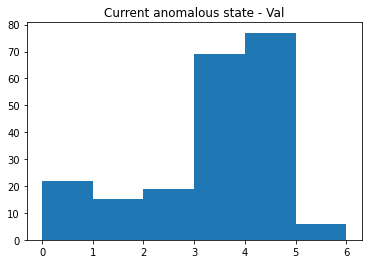

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.399038
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


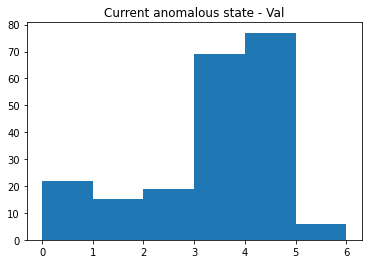

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.730769
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Current threshold value: 0.0783


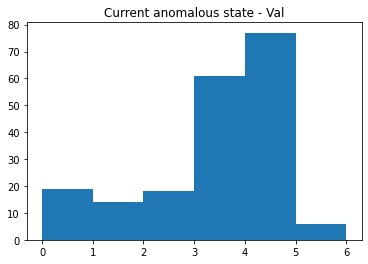

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.425641
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


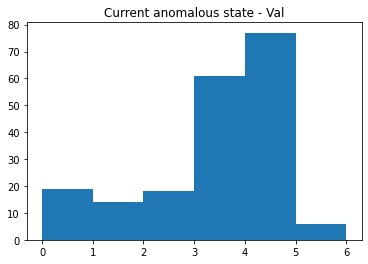

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.738462
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.521739
Current threshold value: 0.0883


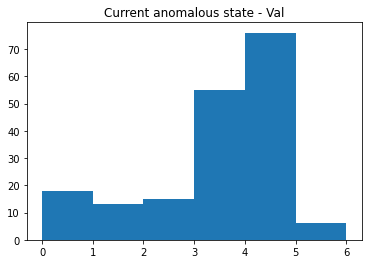

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.448087
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


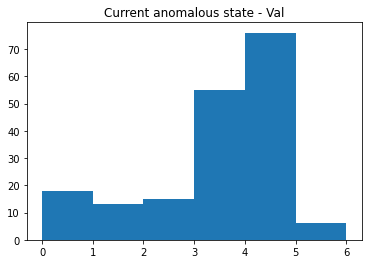

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.748634
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.496377
Current threshold value: 0.0983


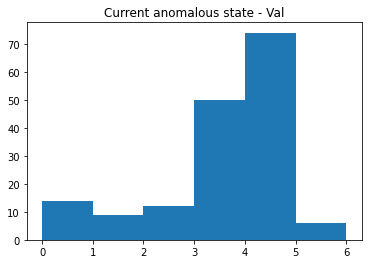

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.484848
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.963855


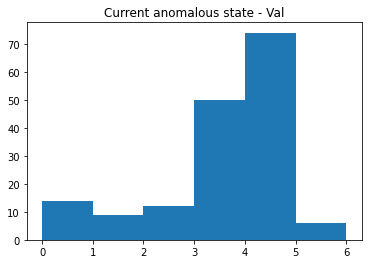

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.787879
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.471014


In [78]:
thresholdTest = [0.0583, 0.0683, 0.0783, 0.0883, 0.0983]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score3, val_arr, value, 'Val')
    processAnomalyWithState3(val_score3, val_arr, value, 'Val')

End with linear activation function. Tanh seems to give the best performance

In [79]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation='tanh')(input_layer)
encoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(3, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(4, activation='linear')(decoder)
#Autoencoder
autoencoder4 = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder4.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_36 (Dense)            (None, 3)                 15        
                                                                 
 dense_37 (Dense)            (None, 2)                 8         
                                                                 
 dense_38 (Dense)            (None, 1)                 3         
                                                                 
 dense_39 (Dense)            (None, 2)                 4         
                                                                 
 dense_40 (Dense)            (None, 3)                 9         
                                                                 
 dense_41 (Dense)            (None, 4)                 16  

In [80]:
fileName4 = "AE_tuneActivation_ends_linear.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName4,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [83]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder4.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [84]:
history4 = autoencoder4.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 1s 3ms/step - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.0830 - val_mean_squared_error: 0.0830
Epoch 2/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0603 - mean_squared_error: 0.0603 - val_loss: 0.0420 - val_mean_squared_error: 0.0420
Epoch 3/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 4/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 5/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 6/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 7/500
147/147 [=

147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 52/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 53/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 54/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 55/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 56/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 57/500
147/147 [=======

147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 102/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 103/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 104/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 105/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 106/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 152/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 153/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 154/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 155/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 156/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 157/

Epoch 250/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 251/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 252/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 253/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 254/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 255/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 256/

Epoch 349/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 350/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 351/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 352/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 353/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 354/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 355/

Epoch 448/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 449/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 450/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 451/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 452/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 453/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 454/

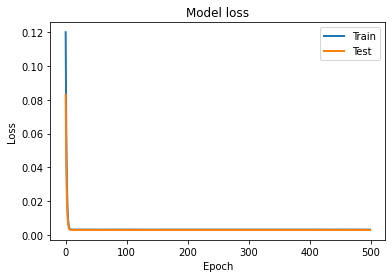

In [85]:
plt.plot(history4['loss'], linewidth=2, label='Train')
plt.plot(history4['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [86]:
autoencoder4 = tf.keras.models.load_model("AE_tuneActivation_ends_linear.h5")

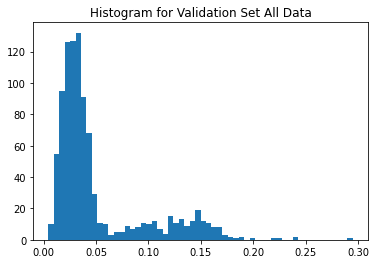

In [87]:
val_predictions4 = autoencoder4.predict(val_arr)
val_score4 = (np.mean(np.power(val_arr - val_predictions4, 2), axis=1))**0.5
plt.hist(val_score4, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

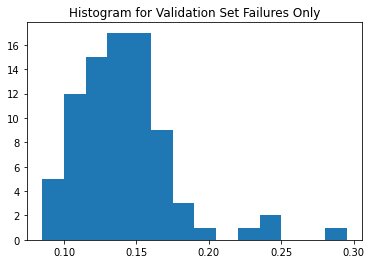

In [88]:
#find anomaly threshold by state
#failure data 
val_failureIndex4 = findFailureIndex(val_state)
val_failureScores4 = getValuebyIndex(val_score4, val_failureIndex4)
plt.hist(val_failureScores4, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

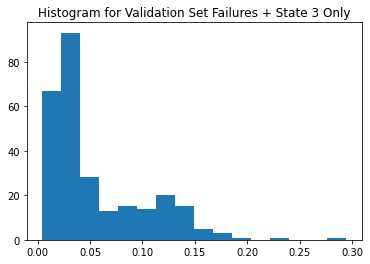

In [89]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex4 = findDegradeIndex(val_state)
val_degradationScores4 = getValuebyIndex(val_score4, val_degradationIndex4)
plt.hist(val_degradationScores2, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

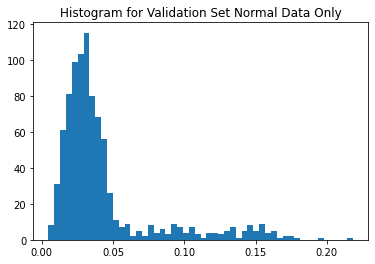

In [90]:
#normal data 
val_normalIndex4 = getNormalIndex(val_state)
val_normalScores4 = getValuebyIndex(val_score4, val_normalIndex4)
plt.hist(val_normalScores4, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [91]:
#find mean (validation)
valMean_normal4 = statistics.mean(val_normalScores4)
valMean_normal4

0.04267123170589302

In [92]:
#find standard deviation (validation)
valStdev_normal4 = statistics.stdev(val_normalScores4)
valStdev_normal4

0.035630634285839485

In [93]:
#1 standard deviation away 
valMean_normal4 + valStdev_normal4

0.0783018659917325

In [94]:
#2 standard deviation away 
valMean_normal4 + valStdev_normal4*2

0.11393250027757199

Current threshold value: 0.0583


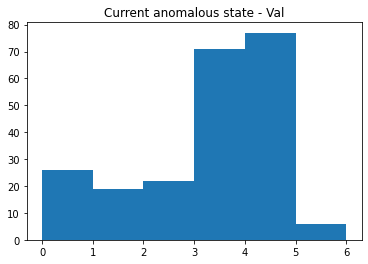

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.375566
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


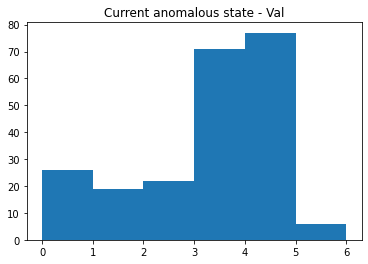

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.696833
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.557971
Current threshold value: 0.0683


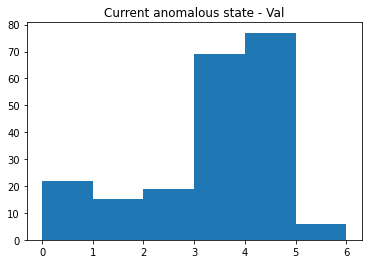

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.399038
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


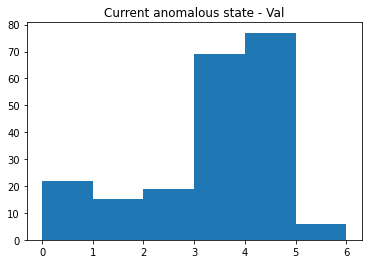

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.730769
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Current threshold value: 0.0783


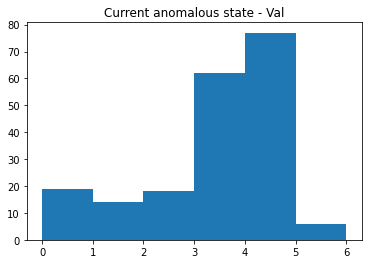

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.423469
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


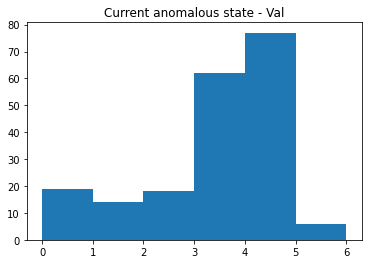

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.739796
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.525362
Current threshold value: 0.0883


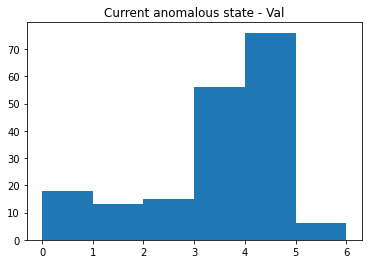

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.445652
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


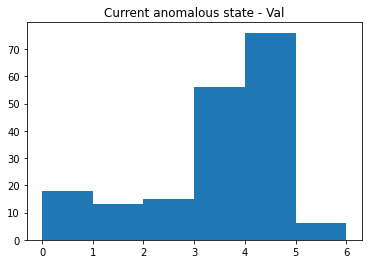

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.750000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000
Current threshold value: 0.0983


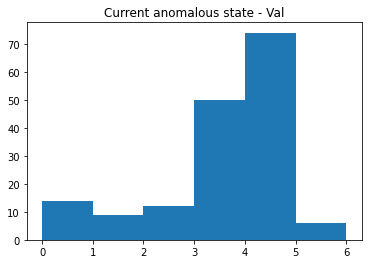

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.484848
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.963855


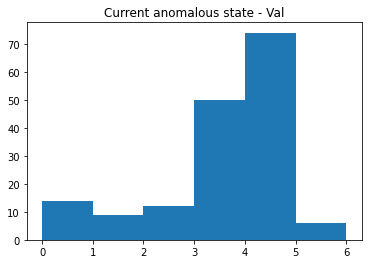

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.787879
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.471014


In [95]:
thresholdTest = [0.0583, 0.0683, 0.0783, 0.0883, 0.0983]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score4, val_arr, value, 'Val')
    processAnomalyWithState3(val_score4, val_arr, value, 'Val')

Use tanh and tanh for end layers. 

### Activation function for body hidden layers

Try out tanh

In [96]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(2, activation="tanh")(encoder)
encoder = tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation="tanh")(encoder)
decoder = tf.keras.layers.Dense(3, activation="tanh")(decoder)
decoder = tf.keras.layers.Dense(4, activation='tanh')(decoder)
#Autoencoder
autoencoder5 = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder5.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_42 (Dense)            (None, 3)                 15        
                                                                 
 dense_43 (Dense)            (None, 2)                 8         
                                                                 
 dense_44 (Dense)            (None, 1)                 3         
                                                                 
 dense_45 (Dense)            (None, 2)                 4         
                                                                 
 dense_46 (Dense)            (None, 3)                 9         
                                                                 
 dense_47 (Dense)            (None, 4)                 16  

In [97]:
fileName5 = "AE_tuneActivation_middle_tanh.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName5,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [98]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder5.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [99]:
history5 = autoencoder5.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 2s 5ms/step - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 2/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 3/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 4/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 5/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 6/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 7/500
147/147 [=

147/147 [==============================] - 1s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 52/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 53/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 54/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 55/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 56/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 57/500
147/147 [=======

147/147 [==============================] - 1s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 102/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 103/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 104/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 105/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 106/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 152/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 153/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 154/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 155/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 156/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 157/

Epoch 250/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 251/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 252/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 253/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 254/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 255/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 256/

Epoch 349/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 350/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 351/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 352/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 353/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 354/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 355/

Epoch 448/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 449/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 450/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 451/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 452/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 453/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 454/

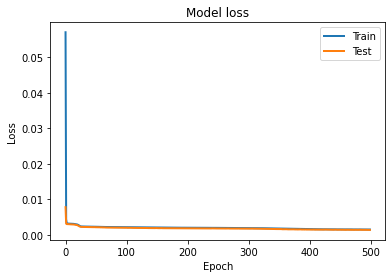

In [100]:
plt.plot(history5['loss'], linewidth=2, label='Train')
plt.plot(history5['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [101]:
autoencoder5 = tf.keras.models.load_model("AE_tuneActivation_middle_tanh.h5")

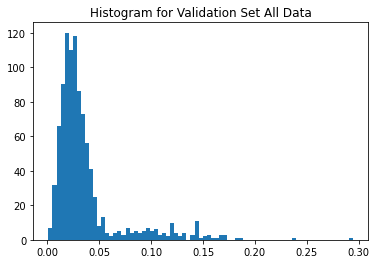

In [102]:
val_predictions5 = autoencoder5.predict(val_arr)
val_score5 = (np.mean(np.power(val_arr - val_predictions5, 2), axis=1))**0.5
plt.hist(val_score2, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

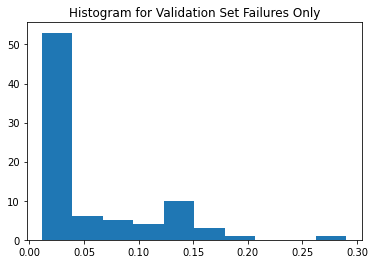

In [103]:
#find anomaly threshold by state
#failure data 
val_failureIndex5 = findFailureIndex(val_state)
val_failureScores5 = getValuebyIndex(val_score5, val_failureIndex5)
plt.hist(val_failureScores5, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

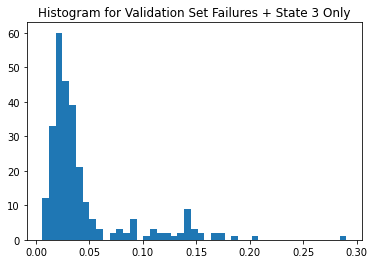

In [104]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex5 = findDegradeIndex(val_state)
val_degradationScores5 = getValuebyIndex(val_score5, val_degradationIndex5)
plt.hist(val_degradationScores5, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

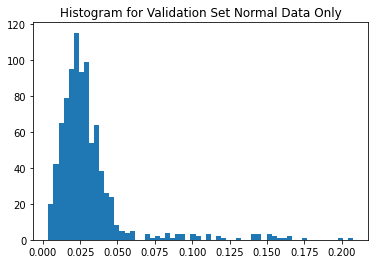

In [105]:
#normal data 
val_normalIndex5 = getNormalIndex(val_state)
val_normalScores5 = getValuebyIndex(val_score5, val_normalIndex5)
plt.hist(val_normalScores5, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [106]:
#find mean (validation)
valMean_normal5 = statistics.mean(val_normalScores5)
valMean_normal5

0.03031718788474034

In [107]:
#find standard deviation (validation)
valStdev_normal5 = statistics.stdev(val_normalScores5)
valStdev_normal5

0.024986662626338932

In [108]:
#1 standard deviation away 
valMean_normal5 + valStdev_normal5

0.05530385051107927

In [109]:
#2 standard deviation away 
valMean_normal5 + valStdev_normal5*2

0.0802905131374182

Current threshold value: 0.0353


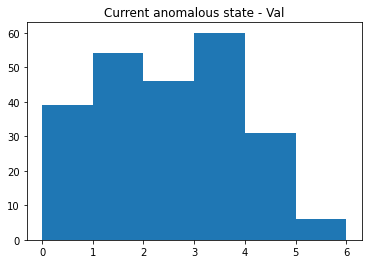

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.156780
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.445783


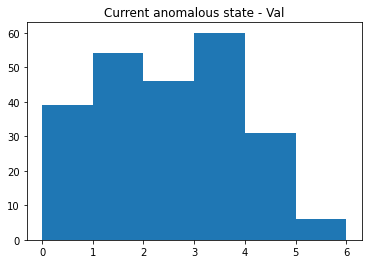

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.411017
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.351449
Current threshold value: 0.0453


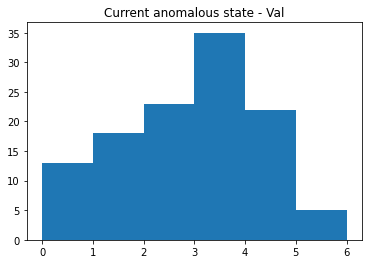

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.232759
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.325301


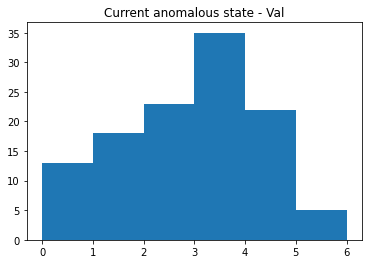

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.534483
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.224638
Current threshold value: 0.0553


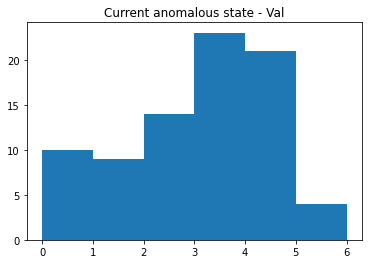

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.308642
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.301205


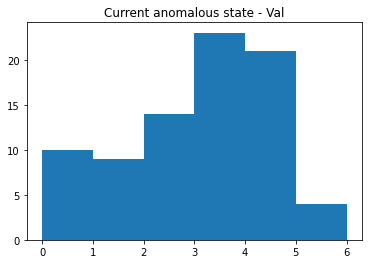

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.592593
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.173913
Current threshold value: 0.0653


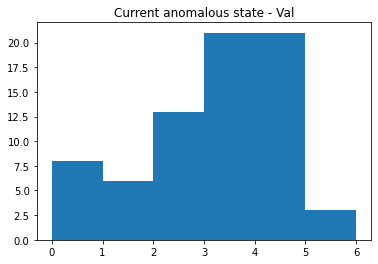

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.333333
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.289157


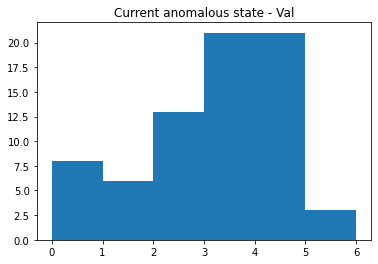

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.625000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.163043
Current threshold value: 0.0753


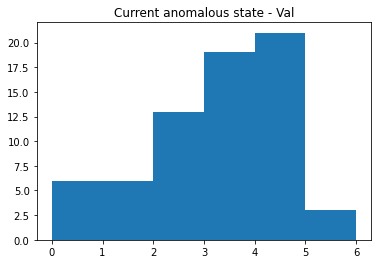

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.352941
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.289157


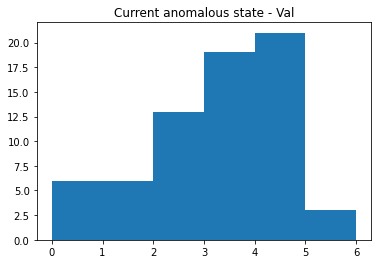

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.632353
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.155797


In [110]:
thresholdTest = [0.0353, 0.0453, 0.0553, 0.0653, 0.0753]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score5, val_arr, value, 'Val')
    processAnomalyWithState3(val_score5, val_arr, value, 'Val')

Try leaky relu

In [111]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(2, activation=tf.nn.leaky_relu)(encoder)
encoder = tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation=tf.nn.leaky_relu)(encoder)
decoder = tf.keras.layers.Dense(3, activation=tf.nn.leaky_relu)(decoder)
decoder = tf.keras.layers.Dense(4, activation='tanh')(decoder)
#Autoencoder
autoencoder6 = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder6.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_48 (Dense)            (None, 3)                 15        
                                                                 
 dense_49 (Dense)            (None, 2)                 8         
                                                                 
 dense_50 (Dense)            (None, 1)                 3         
                                                                 
 dense_51 (Dense)            (None, 2)                 4         
                                                                 
 dense_52 (Dense)            (None, 3)                 9         
                                                                 
 dense_53 (Dense)            (None, 4)                 16  

In [112]:
fileName6 = "AE_tuneActivation_middle_leakyRelu.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName6,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [113]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder6.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [114]:
history6 = autoencoder6.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 2s 6ms/step - loss: 0.1074 - mean_squared_error: 0.1074 - val_loss: 0.0600 - val_mean_squared_error: 0.0600
Epoch 2/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0175 - val_mean_squared_error: 0.0175
Epoch 3/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 4/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 6/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 7/500
147/147 [=

147/147 [==============================] - 1s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 52/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 53/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 54/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 55/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 56/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 57/500
147/147 [=======

147/147 [==============================] - 0s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 102/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 103/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 104/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 105/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 106/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 152/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 153/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 154/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 155/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 156/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 157/

Epoch 250/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 251/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 252/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 253/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 254/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 255/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 256/

Epoch 349/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 350/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 351/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 352/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 353/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 354/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 355/

Epoch 448/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 449/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 450/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 451/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 452/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 453/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 454/

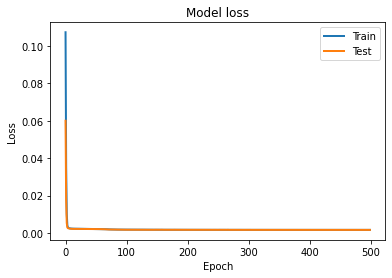

In [115]:
plt.plot(history6['loss'], linewidth=2, label='Train')
plt.plot(history6['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [116]:
autoencoder6 = tf.keras.models.load_model("AE_tuneActivation_middle_leakyRelu.h5")

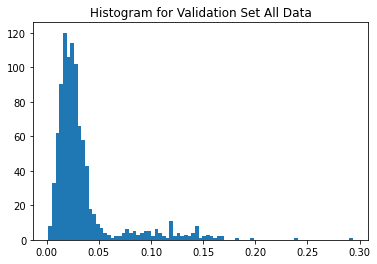

In [117]:
val_predictions6 = autoencoder6.predict(val_arr)
val_score6 = (np.mean(np.power(val_arr - val_predictions6, 2), axis=1))**0.5
plt.hist(val_score6, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

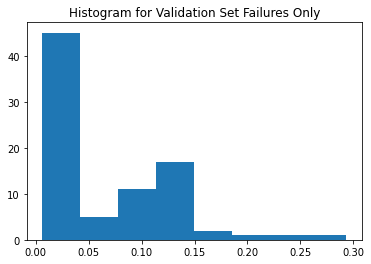

In [118]:
#find anomaly threshold by state
#failure data 
val_failureIndex6 = findFailureIndex(val_state)
val_failureScores6 = getValuebyIndex(val_score6, val_failureIndex6)
plt.hist(val_failureScores6, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

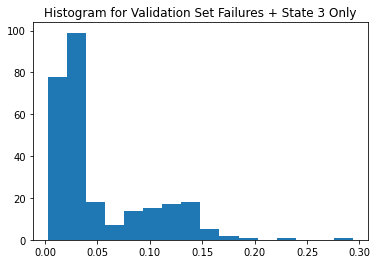

In [119]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex6 = findDegradeIndex(val_state)
val_degradationScores6 = getValuebyIndex(val_score6, val_degradationIndex6)
plt.hist(val_degradationScores6, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

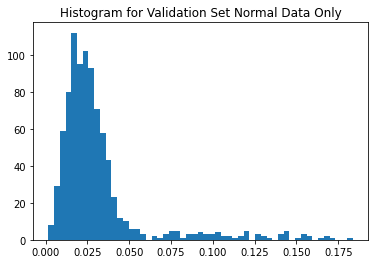

In [120]:
#normal data 
val_normalIndex6 = getNormalIndex(val_state)
val_normalScores6 = getValuebyIndex(val_score6, val_normalIndex6)
plt.hist(val_normalScores6, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [121]:
#find mean (validation)
valMean_normal6 = statistics.mean(val_normalScores6)
valMean_normal6

0.03115991485330729

In [122]:
#find standard deviation (validation)
valStdev_normal6 = statistics.stdev(val_normalScores6)
valStdev_normal6

0.027697861445669984

In [123]:
#1 standard deviation away 
valMean_normal6 + valStdev_normal6

0.058857776298977274

In [124]:
#2 standard deviation away 
valMean_normal6 + valStdev_normal6*2

0.08655563774464725

Current threshold value: 0.0389


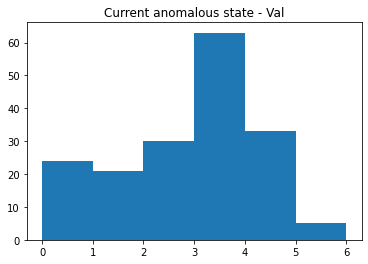

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.215909
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.457831


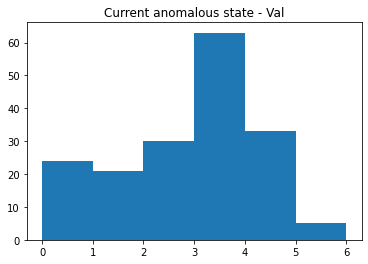

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.573864
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.365942
Current threshold value: 0.0489


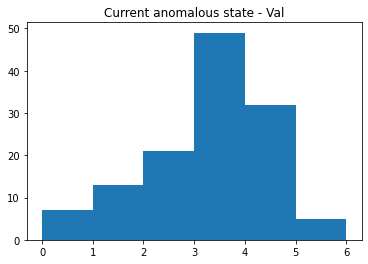

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.291339
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.445783


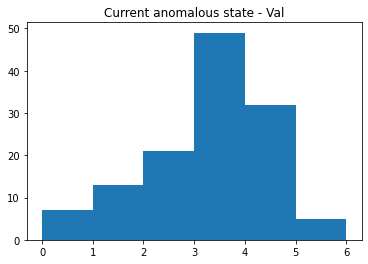

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.677165
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.311594
Current threshold value: 0.0589


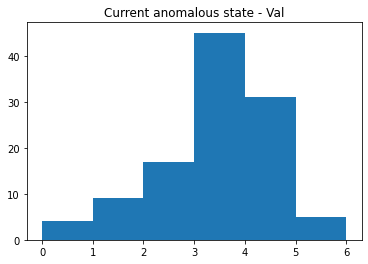

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.324324
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.433735


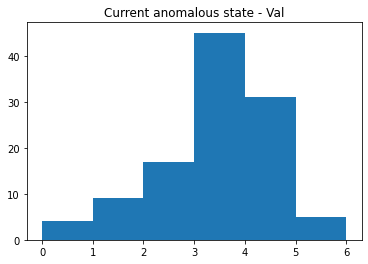

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.729730
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.293478
Current threshold value: 0.0689


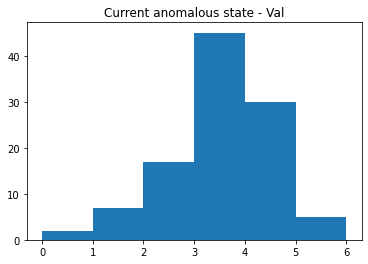

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.330189
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.421687


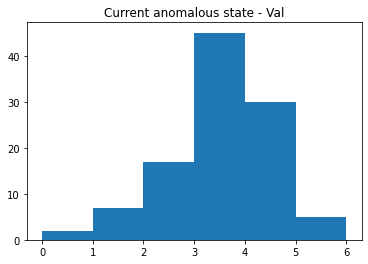

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.754717
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.289855
Current threshold value: 0.0789


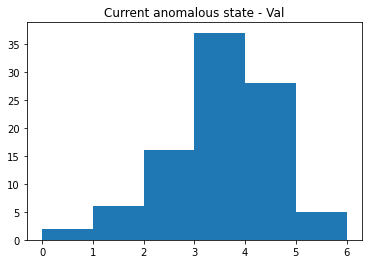

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.351064
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.397590


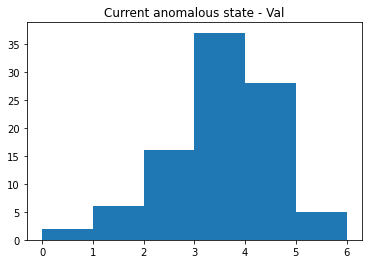

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.744681
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.253623


In [125]:
thresholdTest = [0.0389, 0.0489, 0.0589, 0.0689, 0.0789]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score6, val_arr, value, 'Val')
    processAnomalyWithState3(val_score6, val_arr, value, 'Val')

Try sigmoid 

In [126]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(2, activation='sigmoid')(encoder)
encoder = tf.keras.layers.Dense(1, activation='sigmoid')(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='sigmoid')(encoder)
decoder = tf.keras.layers.Dense(3, activation='sigmoid')(decoder)
decoder = tf.keras.layers.Dense(4, activation='tanh')(decoder)
#Autoencoder
autoencoder7 = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder7.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_54 (Dense)            (None, 3)                 15        
                                                                 
 dense_55 (Dense)            (None, 2)                 8         
                                                                 
 dense_56 (Dense)            (None, 1)                 3         
                                                                 
 dense_57 (Dense)            (None, 2)                 4         
                                                                 
 dense_58 (Dense)            (None, 3)                 9         
                                                                 
 dense_59 (Dense)            (None, 4)                 16  

In [127]:
fileName7 = "AE_tuneActivation_middle_sigmoid.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName7,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [128]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder7.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [129]:
history7 = autoencoder7.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 2s 5ms/step - loss: 0.2267 - mean_squared_error: 0.2267 - val_loss: 0.1095 - val_mean_squared_error: 0.1095
Epoch 2/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0616 - mean_squared_error: 0.0616 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 3/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 4/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 5/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 6/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 7/500
147/147 [=

147/147 [==============================] - 0s 3ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 52/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 53/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 54/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 55/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 56/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 57/500
147/147 [=======

147/147 [==============================] - 0s 3ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 102/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 103/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 104/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 105/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 106/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 152/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 153/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 154/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 155/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 156/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 157/

Epoch 250/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 251/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 252/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 253/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 254/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 255/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 256/

Epoch 349/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 350/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 351/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 352/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 353/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 354/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 355/

Epoch 448/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 449/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 450/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 451/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 452/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 453/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 454/

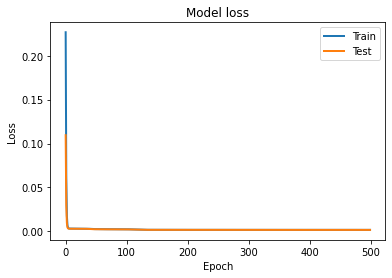

In [130]:
plt.plot(history7['loss'], linewidth=2, label='Train')
plt.plot(history7['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [131]:
autoencoder7 = tf.keras.models.load_model("AE_tuneActivation_middle_sigmoid.h5")

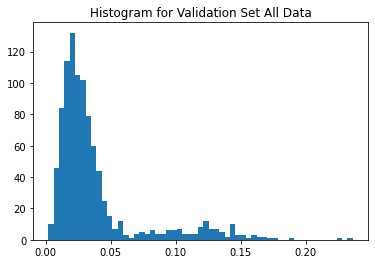

In [132]:
val_predictions7 = autoencoder7.predict(val_arr)
val_score7 = (np.mean(np.power(val_arr - val_predictions7, 2), axis=1))**0.5
plt.hist(val_score7, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

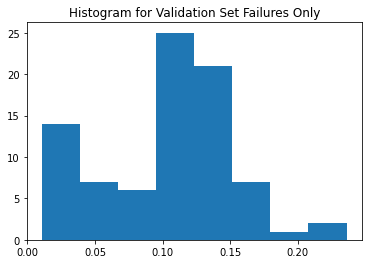

In [133]:
#find anomaly threshold by state
#failure data 
val_failureIndex7 = findFailureIndex(val_state)
val_failureScores7 = getValuebyIndex(val_score7, val_failureIndex7)
plt.hist(val_failureScores7, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

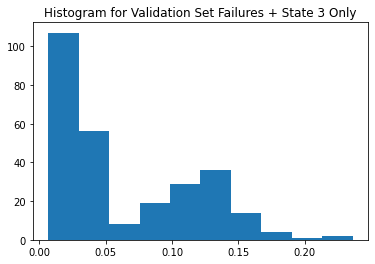

In [134]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex7 = findDegradeIndex(val_state)
val_degradationScores7 = getValuebyIndex(val_score7, val_degradationIndex7)
plt.hist(val_degradationScores7, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

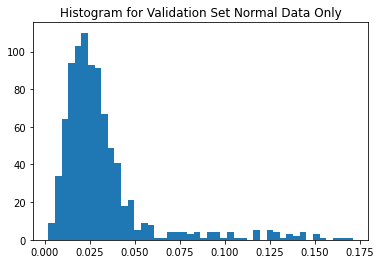

In [135]:
#normal data 
val_normalIndex7 = getNormalIndex(val_state)
val_normalScores7 = getValuebyIndex(val_score7, val_normalIndex7)
plt.hist(val_normalScores7, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [136]:
#find mean (validation)
valMean_normal7 = statistics.mean(val_normalScores7)
valMean_normal7

0.031669258880811894

In [137]:
#find standard deviation (validation)
valStdev_normal7 = statistics.stdev(val_normalScores7)
valStdev_normal7

0.025912334058496665

In [138]:
#1 standard deviation away 
valMean_normal7 + valStdev_normal7

0.05758159293930856

In [139]:
#2 standard deviation away 
valMean_normal7 + valStdev_normal7*2

0.08349392699780522

Current threshold value: 0.0376


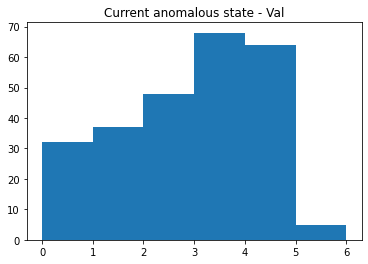

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.271654
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.831325


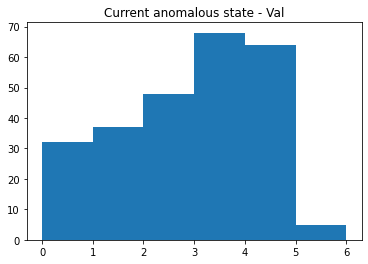

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.539370
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.496377
Current threshold value: 0.0476


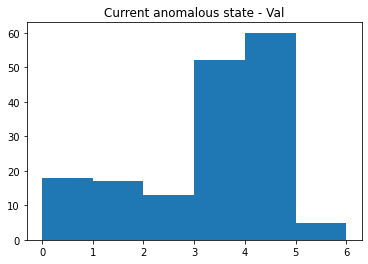

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.393939
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.783133


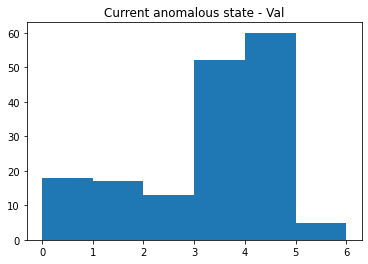

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.709091
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.423913
Current threshold value: 0.0576


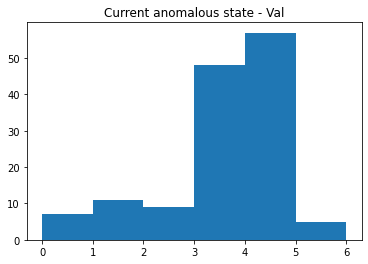

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.452555
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.746988


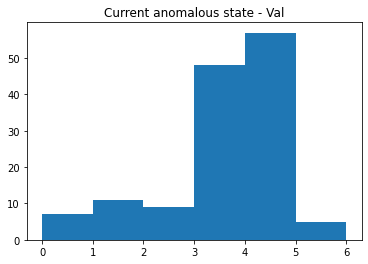

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.802920
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.398551
Current threshold value: 0.0676


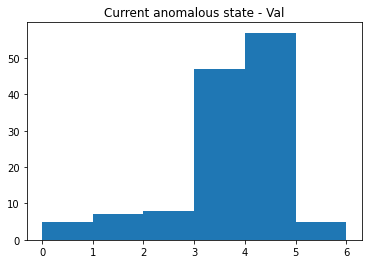

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.480620
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.746988


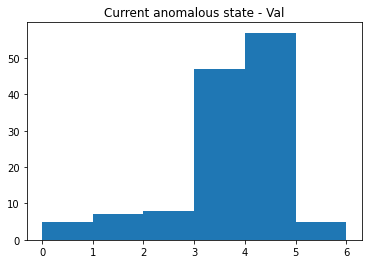

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.844961
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.394928
Current threshold value: 0.0776


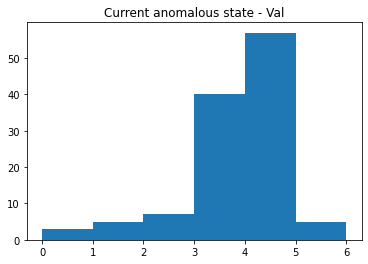

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.529915
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.746988


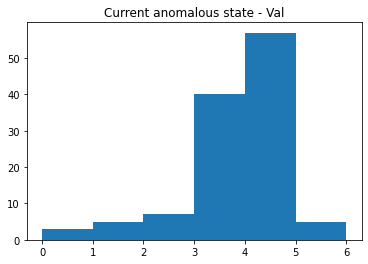

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.871795
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.369565


In [140]:
thresholdTest = [0.0376, 0.0476, 0.0576, 0.0676, 0.0776]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score7, val_arr, value, 'Val')
    processAnomalyWithState3(val_score7, val_arr, value, 'Val')

relu in the body layer gave the best performance

### Activation function for middle hidden layer

tanh in middle code layer

In [24]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(1, activation="tanh")(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(3, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(4, activation='tanh')(decoder)
#Autoencoder
autoencoder8 = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder8.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 15        
                                                                 
 dense_7 (Dense)             (None, 2)                 8         
                                                                 
 dense_8 (Dense)             (None, 1)                 3         
                                                                 
 dense_9 (Dense)             (None, 2)                 4         
                                                                 
 dense_10 (Dense)            (None, 3)                 9         
                                                                 
 dense_11 (Dense)            (None, 4)                 16  

In [25]:
fileName8 = "AE_tuneActivation_code_tanh.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName8,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [26]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder8.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [27]:
history8 = autoencoder8.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 9s 9ms/step - loss: 0.0938 - mean_squared_error: 0.0938 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 2/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 3/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 4/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 5/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 6/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 7/500
147/147 [=

147/147 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 52/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 53/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 54/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 55/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 56/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 57/500
147/147 [=======

147/147 [==============================] - 1s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 102/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 103/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 104/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 105/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 106/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 152/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 153/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 154/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 155/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 156/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 157/

Epoch 250/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 251/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 252/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 253/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 254/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 255/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 256/

Epoch 349/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 350/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 351/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 352/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 353/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 354/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 355/

Epoch 448/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 449/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 450/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 451/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 452/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 453/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 454/

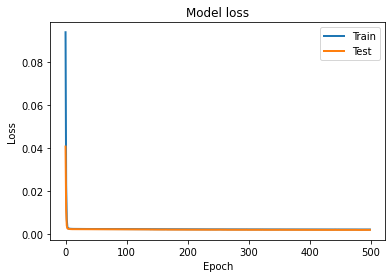

In [28]:
plt.plot(history8['loss'], linewidth=2, label='Train')
plt.plot(history8['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [29]:
autoencoder8 = tf.keras.models.load_model("AE_tuneActivation_code_tanh.h5")

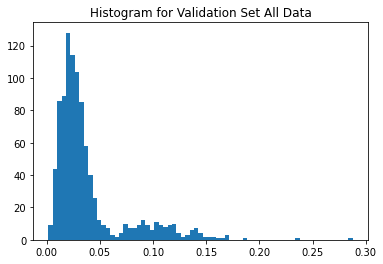

In [30]:
val_predictions8 = autoencoder8.predict(val_arr)
val_score8 = (np.mean(np.power(val_arr - val_predictions8, 2), axis=1))**0.5
plt.hist(val_score8, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

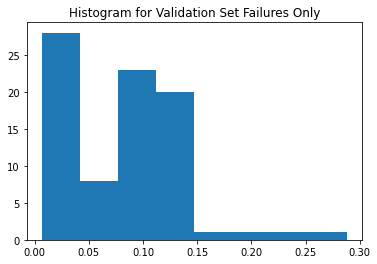

In [38]:
#find anomaly threshold by state
#failure data 
val_failureIndex8 = findFailureIndex(val_state)
val_failureScores8 = getValuebyIndex(val_score8, val_failureIndex8)
plt.hist(val_failureScores8, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

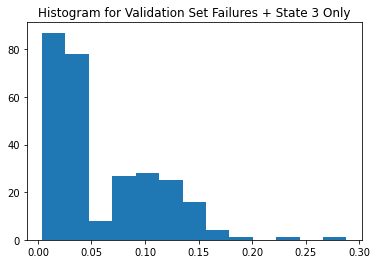

In [39]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex8 = findDegradeIndex(val_state)
val_degradationScores8 = getValuebyIndex(val_score8, val_degradationIndex8)
plt.hist(val_degradationScores8, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

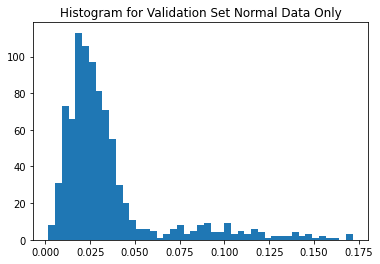

In [40]:
#normal data 
val_normalIndex8 = getNormalIndex(val_state)
val_normalScores8 = getValuebyIndex(val_score8, val_normalIndex8)
plt.hist(val_normalScores8, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [41]:
import statistics
#find mean (validation)
valMean_normal8 = statistics.mean(val_normalScores8)
valMean_normal8

0.03457463152883123

In [42]:
#find standard deviation (validation)
valStdev_normal8 = statistics.stdev(val_normalScores8)
valStdev_normal8

0.02934167218950922

In [43]:
#1 standard deviation away 
valMean_normal8 + valStdev_normal8

0.06391630371834045

In [44]:
#2 standard deviation away 
valMean_normal8 + valStdev_normal8*2

0.09325797590784968

Current threshold value: 0.0439


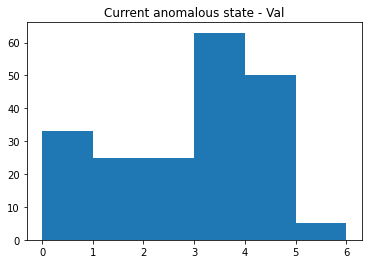

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.273632
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.662651


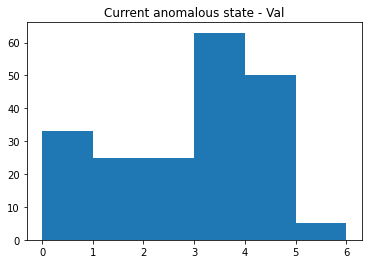

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.587065
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.427536
Current threshold value: 0.0539


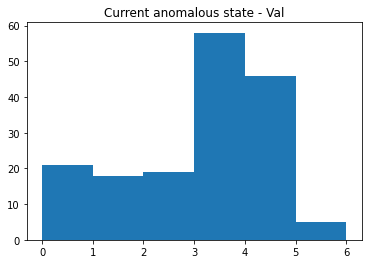

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.305389
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.614458


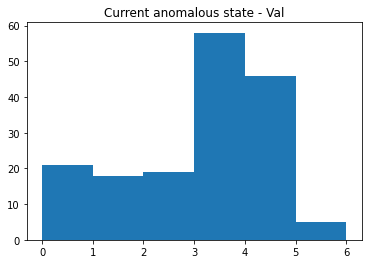

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.652695
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.394928
Current threshold value: 0.0639


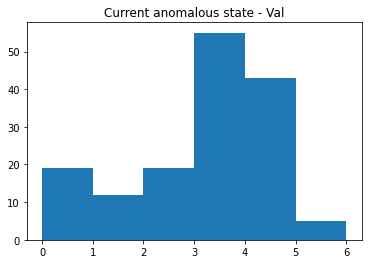

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.313725
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.578313


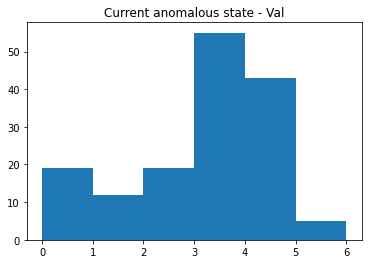

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.673203
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.373188
Current threshold value: 0.0739


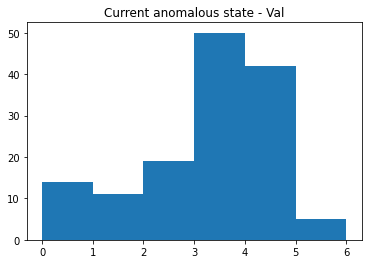

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.333333
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.566265


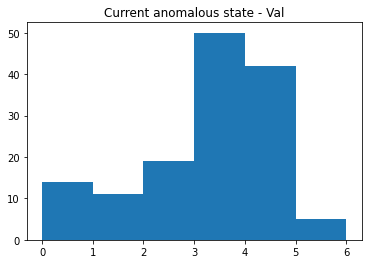

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.687943
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.351449
Current threshold value: 0.0839


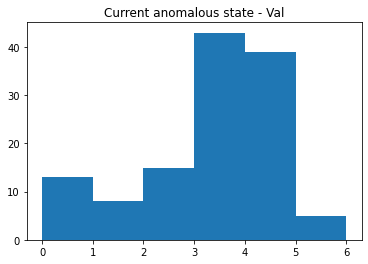

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.357724
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.530120


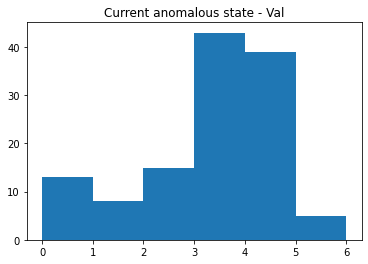

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.707317
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.315217


In [46]:
thresholdTest = [0.0439, 0.0539, 0.0639, 0.0739, 0.0839]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score8, val_arr, value, 'Val')
    processAnomalyWithState3(val_score8, val_arr, value, 'Val')

relu in middle code layer

In [48]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(1, activation="relu")(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(3, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(4, activation='tanh')(decoder)
#Autoencoder
autoencoder9 = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder9.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_18 (Dense)            (None, 3)                 15        
                                                                 
 dense_19 (Dense)            (None, 2)                 8         
                                                                 
 dense_20 (Dense)            (None, 1)                 3         
                                                                 
 dense_21 (Dense)            (None, 2)                 4         
                                                                 
 dense_22 (Dense)            (None, 3)                 9         
                                                                 
 dense_23 (Dense)            (None, 4)                 16  

In [50]:
fileName9 = "AE_tuneActivation_code_relu.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName9,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [51]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder9.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [52]:
history9 = autoencoder9.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 2s 5ms/step - loss: 0.1202 - mean_squared_error: 0.1202 - val_loss: 0.0836 - val_mean_squared_error: 0.0836
Epoch 2/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0616 - mean_squared_error: 0.0616 - val_loss: 0.0441 - val_mean_squared_error: 0.0441
Epoch 3/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0249 - val_mean_squared_error: 0.0249
Epoch 4/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 5/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 6/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 7/500
147/147 [=

147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 52/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 53/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 54/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 55/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 56/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 57/500
147/147 [=======

147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 102/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 103/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 104/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 105/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 106/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 152/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 153/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 154/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 155/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 156/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 157/

Epoch 250/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 251/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 252/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 253/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 254/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 255/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 256/

Epoch 349/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 350/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 351/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 352/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 353/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 354/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 355/

Epoch 448/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 449/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 450/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 451/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 452/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 453/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 454/

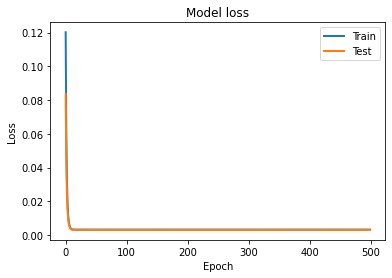

In [53]:
plt.plot(history9['loss'], linewidth=2, label='Train')
plt.plot(history9['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [54]:
autoencoder9 = tf.keras.models.load_model("AE_tuneActivation_code_relu.h5")

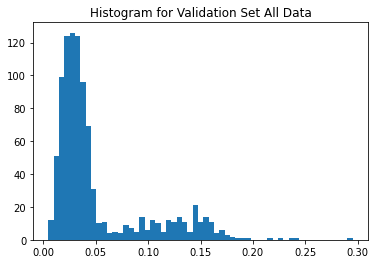

In [55]:
val_predictions9 = autoencoder9.predict(val_arr)
val_score9 = (np.mean(np.power(val_arr - val_predictions9, 2), axis=1))**0.5
plt.hist(val_score9, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

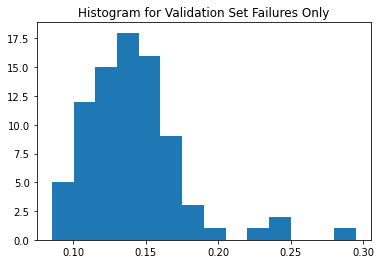

In [56]:
#find anomaly threshold by state
#failure data 
val_failureIndex9 = findFailureIndex(val_state)
val_failureScores9 = getValuebyIndex(val_score9, val_failureIndex9)
plt.hist(val_failureScores9, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

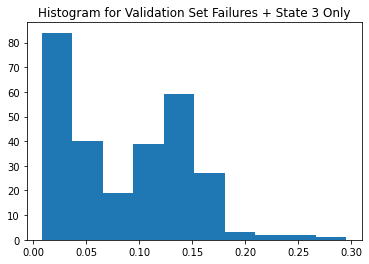

In [57]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex9 = findDegradeIndex(val_state)
val_degradationScores9 = getValuebyIndex(val_score9, val_degradationIndex9)
plt.hist(val_degradationScores9, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

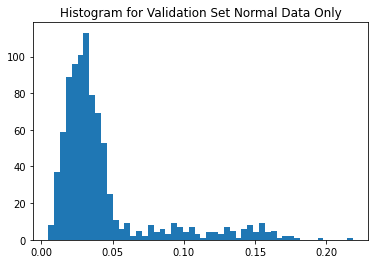

In [59]:
#normal data 
val_normalIndex9 = getNormalIndex(val_state)
val_normalScores9 = getValuebyIndex(val_score9, val_normalIndex9)
plt.hist(val_normalScores9, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [60]:
#find mean (validation)
valMean_normal9 = statistics.mean(val_normalScores9)
valMean_normal9

0.042627747010021

In [61]:
#find standard deviation (validation)
valStdev_normal9 = statistics.stdev(val_normalScores9)
valStdev_normal9

0.03570343135482483

In [62]:
#1 standard deviation away 
valMean_normal9 + valStdev_normal9

0.07833117836484582

In [63]:
#2 standard deviation away 
valMean_normal9 + valStdev_normal9*2

0.11403460971967067

Current threshold value: 0.0583


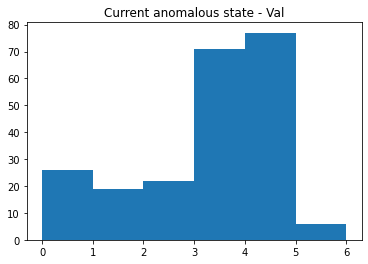

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.375566
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


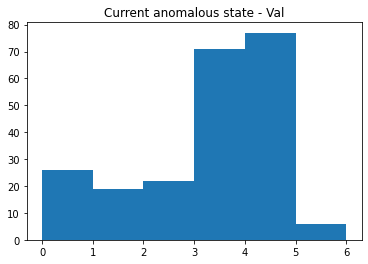

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.696833
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.557971
Current threshold value: 0.0683


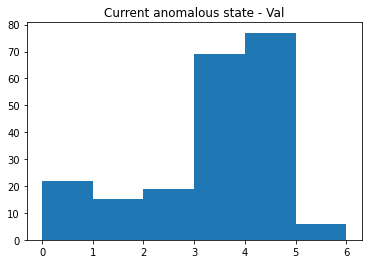

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.399038
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


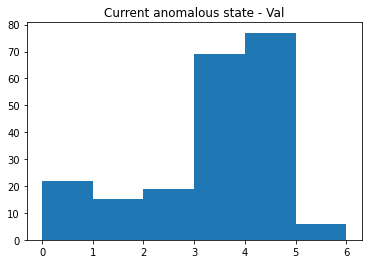

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.730769
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Current threshold value: 0.0783


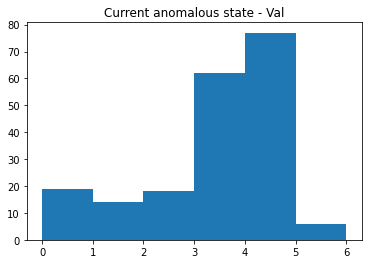

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.423469
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


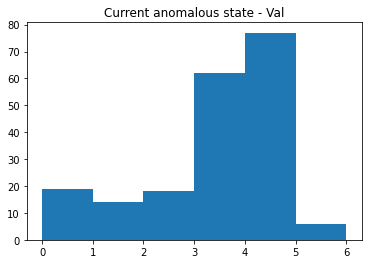

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.739796
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.525362
Current threshold value: 0.0883


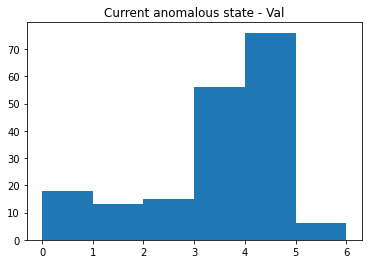

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.445652
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


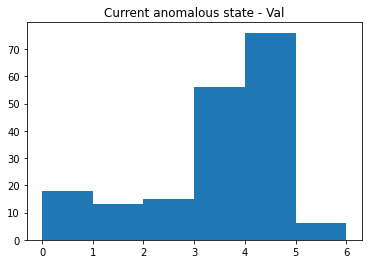

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.750000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000
Current threshold value: 0.0983


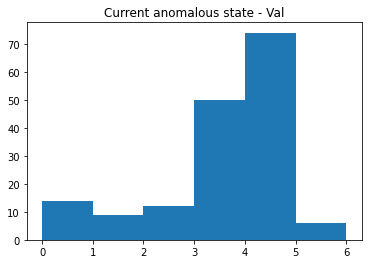

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.484848
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.963855


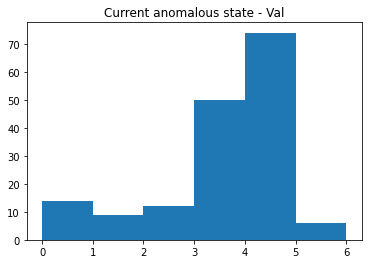

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.787879
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.471014


In [64]:
thresholdTest = [0.0583, 0.0683, 0.0783, 0.0883, 0.0983]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score9, val_arr, value, 'Val')
    processAnomalyWithState3(val_score9, val_arr, value, 'Val')

Try sigmoid in code layer

In [65]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(1, activation="sigmoid")(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(3, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(4, activation='tanh')(decoder)
#Autoencoder
autoencoder10 = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder10.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_24 (Dense)            (None, 3)                 15        
                                                                 
 dense_25 (Dense)            (None, 2)                 8         
                                                                 
 dense_26 (Dense)            (None, 1)                 3         
                                                                 
 dense_27 (Dense)            (None, 2)                 4         
                                                                 
 dense_28 (Dense)            (None, 3)                 9         
                                                                 
 dense_29 (Dense)            (None, 4)                 16  

In [66]:
fileName10 = "AE_tuneActivation_code_sigmoid.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName10,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [67]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder10.compile(metrics=[tf.keras.metrics.MeanSquaredError()],
                    loss='mean_squared_error',
                    optimizer=adam)

In [68]:
history10 = autoencoder10.fit(trainNormal1_arr, trainNormal1_arr,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(trainNormal2_arr, trainNormal2_arr),
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                    ).history

Epoch 1/500
147/147 [==============================] - 2s 5ms/step - loss: 0.1703 - mean_squared_error: 0.1703 - val_loss: 0.0910 - val_mean_squared_error: 0.0910
Epoch 2/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0446 - val_mean_squared_error: 0.0446
Epoch 3/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 4/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 5/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 6/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 7/500
147/147 [=

147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 52/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 53/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 54/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 55/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 56/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 57/500
147/147 [=======

147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 102/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 103/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 104/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 105/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 106/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 107/500
147/147 [=

Epoch 151/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 152/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 153/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 154/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 155/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 156/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 157/

Epoch 250/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 251/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 252/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 253/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 254/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 255/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 256/

Epoch 349/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 350/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 351/500
147/147 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 352/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 353/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 354/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 355/

Epoch 448/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 449/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 450/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 451/500
147/147 [==============================] - 1s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 452/500
147/147 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 453/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 454/

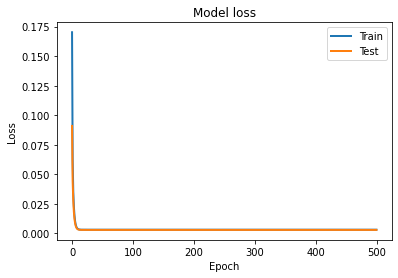

In [69]:
plt.plot(history10['loss'], linewidth=2, label='Train')
plt.plot(history10['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [70]:
autoencoder10 = tf.keras.models.load_model("AE_tuneActivation_code_sigmoid.h5")

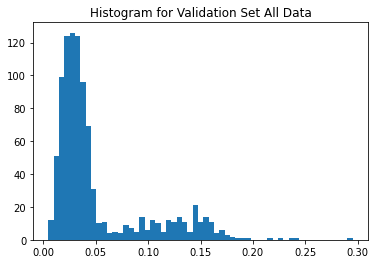

In [71]:
val_predictions10 = autoencoder10.predict(val_arr)
val_score10 = (np.mean(np.power(val_arr - val_predictions10, 2), axis=1))**0.5
plt.hist(val_score10, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

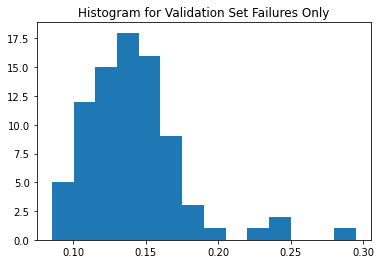

In [72]:
#find anomaly threshold by state
#failure data 
val_failureIndex10 = findFailureIndex(val_state)
val_failureScores10 = getValuebyIndex(val_score10, val_failureIndex10)
plt.hist(val_failureScores10, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

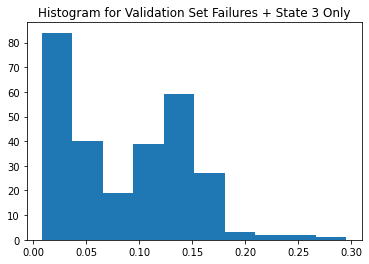

In [73]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex10 = findDegradeIndex(val_state)
val_degradationScores10 = getValuebyIndex(val_score10, val_degradationIndex10)
plt.hist(val_degradationScores10, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

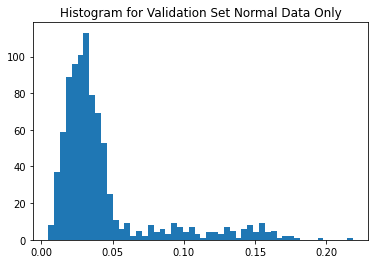

In [74]:
#normal data 
val_normalIndex10 = getNormalIndex(val_state)
val_normalScores10 = getValuebyIndex(val_score10, val_normalIndex10)
plt.hist(val_normalScores10, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [75]:
#find mean (validation)
valMean_normal10 = statistics.mean(val_normalScores10)
valMean_normal10

0.042627870800913605

In [76]:
#find standard deviation (validation)
valStdev_normal10 = statistics.stdev(val_normalScores10)
valStdev_normal10

0.03570332577072562

In [77]:
#1 standard deviation away 
valMean_normal10 + valStdev_normal10

0.07833119657163923

In [78]:
#2 standard deviation away 
valMean_normal10 + valStdev_normal10*2

0.11403452234236486

Current threshold value: 0.0583


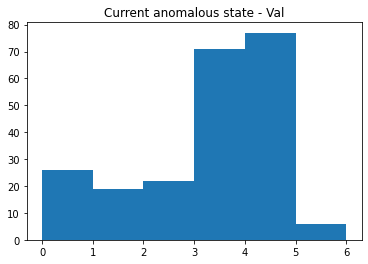

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.375566
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


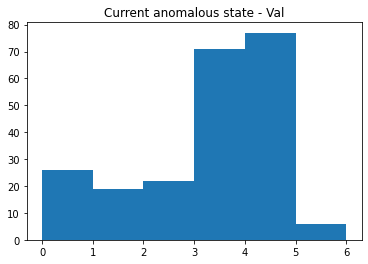

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.696833
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.557971
Current threshold value: 0.0683


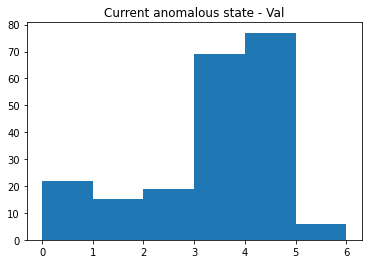

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.399038
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


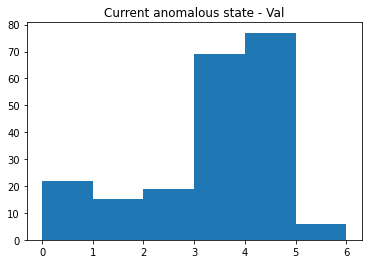

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.730769
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Current threshold value: 0.0783


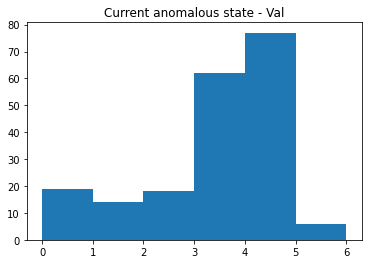

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.423469
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


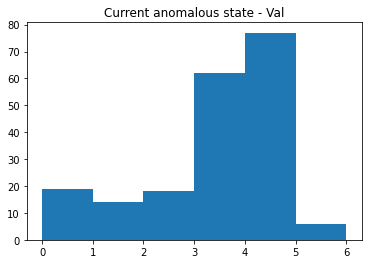

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.739796
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.525362
Current threshold value: 0.0883


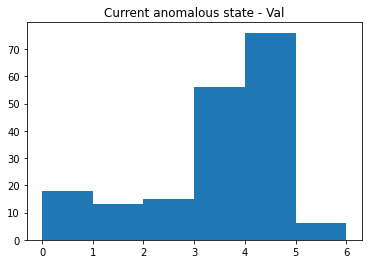

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.445652
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


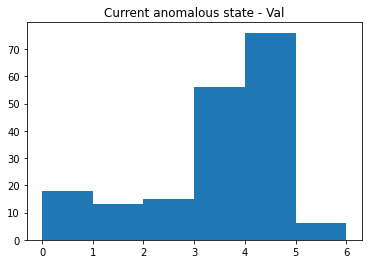

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.750000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000
Current threshold value: 0.0983


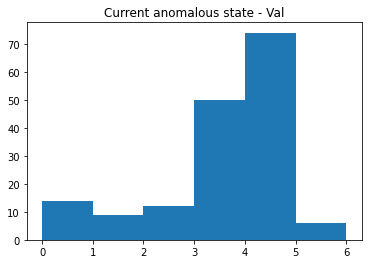

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.484848
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.963855


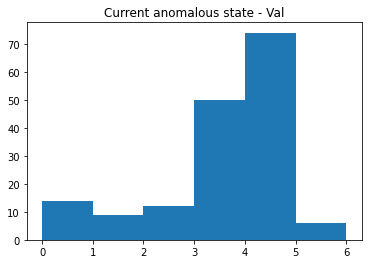

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.787879
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.471014


In [79]:
thresholdTest = [0.0583, 0.0683, 0.0783, 0.0883, 0.0983]
for value in thresholdTest:
    print('Current threshold value: %.4f' % value)
    processAnomalyWithoutState3(val_score10, val_arr, value, 'Val')
    processAnomalyWithState3(val_score10, val_arr, value, 'Val')

relu, leaky relu and sigmoid gives similar performance. Use relu